In [74]:
import numpy as np
from math import pi
from gdshelpers.geometry.chip import Cell
from gdshelpers.parts.waveguide import Waveguide
from gdshelpers.parts.coupler import GratingCoupler
from gdshelpers.parts.resonator import RingResonator
from gdshelpers.parts.splitter import Splitter
from gdshelpers.layout import GridLayout
from gdshelpers.parts.marker import CrossMarker
from gdshelpers.parts.marker import SquareMarker
from gdshelpers.helpers.positive_resist import convert_to_positive_resist
from gdshelpers.parts.port import Port
from shapely.geometry import Polygon
from shapely.affinity import scale
from shapely.affinity import translate
from shapely.affinity import rotate
from gdshelpers.geometry import geometric_union
from gdshelpers.helpers.under_etching import create_holes_for_under_etching
from gdshelpers.geometry.ebl_frame_generators import raith_marker_frame
from gdshelpers.parts.text import Text
from shapely.geometry import Point

In [75]:
# Import help functions written by I-Tung
import importlib
import make_displaced_IDT_pair
importlib.reload(make_displaced_IDT_pair)
import make_zno_pad
importlib.reload(make_zno_pad)
import make_SOS_Optomechanic_Rings_bend_Input_acoustic
importlib.reload(make_SOS_Optomechanic_Rings_bend_Input_acoustic)

<module 'make_SOS_Optomechanic_Rings_bend_Input_acoustic' from '/Users/haoqindeng/Desktop/Qtransduction/IDT_gds/make_SOS_Optomechanic_Rings_bend_Input_acoustic.py'>

In [76]:
# Parameters to change

# The vertical displacement distance between the two IDT (left with respect to right)
y_displacement_for_IDT = -50 #um
y_displacement_for_IDT = 0 #um

# sweep 1 is designated to the acoustic coupling gap
sweep1 = 0.1 #um

# sweep 2 is designated to the acoustic waveguide propagation length
sweep2 = 1000 #um

In [79]:
import importlib
import aco_components
importlib.reload(aco_components)
import math

[(-763.6, -8), (-763.6, -3), (-955.6, -3), (-955.6, -8)]
[(-763.6, 17.5), (-763.6, 12.5), (-955.6, 12.5), (-955.6, 17.5)]
[(-86.4, -8), (-86.4, -3), (105.6, -3), (105.6, -8)]
[(-86.4, 17.5), (-86.4, 12.5), (105.6, 12.5), (105.6, 17.5)]
y_mid_IDT  9.75
top_right_x  101.6
shift_2  96.0
left_x_coor_TR  -763.6
left_y_coor_TR  12.5
right_top_small_pad_TL_X  -86.4
right_top_small_pad_TL_Y 19.5
[[(-763.6, -8), (-763.6, -3), (-955.6, -3), (-955.6, -8)], [(-763.6, 17.5), (-763.6, 12.5), (-955.6, 12.5), (-955.6, 17.5)], [(-86.4, -8), (-86.4, -3), (105.6, -3), (105.6, -8)], [(-86.4, 17.5), (-86.4, 12.5), (105.6, 12.5), (105.6, 17.5)]]
wg down port:  (-608.8, 3.4499999999999997)
wg down port:  (-608.8, 3.4499999999999997)


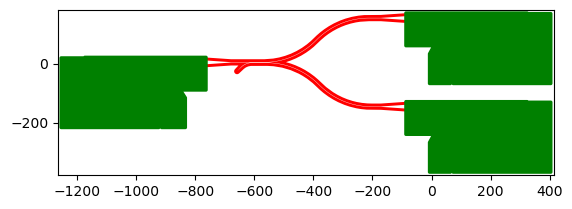

In [81]:
#Make the IDT fingers

# Modified from for the BGaP OMR paper (before 2023-04-17): figer_widths=0.5017, number_of_pairs=80, IDT_Aperature=15, prop_length=200+160+300+200
# New parameters for Si-on-sapphire substrates (2023-04-20): figer_widths=0.25, number_of_pairs=65, IDT_Aperature=100, prop_length=sweep1
# Note on prop length, for rings the proplength needs to be longer add 500 instead of 300: 200+160+300 to ACWG_ONLY:200+160+300 RR:200+160+500 , MZI 200+160+200 , ORR_BENT = 200+160+300
# Figer_width = 1/4 of acoustic wavelength
prop_len = 200
IDT_1, IDT_1_bigpad, \
IDT_2, IDT_2_bigpad, \
top_right_x, y_mid_IDT, shift_2, \
right_top_small_pad_TL_X, right_top_small_pad_TL_Y,\
left_x_coord_TR, left_y_coord_TR, port_coordinates = make_displaced_IDT_pair.make_displaced_IDT_pairs(figer_widths=0.45, number_of_pairs=80,
                                                                    IDT_Aperature=15, prop_length= 200+300+100+50+prop_len, y_displacement= y_displacement_for_IDT)
# For 2.5 GHz IDT, 1/4 wavelength = 0.45 um
print('y_mid_IDT ', y_mid_IDT)
print('top_right_x ', top_right_x)
print('shift_2 ', shift_2)
print('left_x_coor_TR ', left_x_coord_TR)
print('left_y_coor_TR ', left_y_coord_TR)
print('right_top_small_pad_TL_X ', right_top_small_pad_TL_X)
print('right_top_small_pad_TL_Y', right_top_small_pad_TL_Y)
print(port_coordinates)
wg_right_org_x = top_right_x
wg_right_org_y = (port_coordinates[0][1][1] + port_coordinates[1][1][1]) / 2 + 150
wg_right_width = 15
wg_right_len = 172.8

wg_left_org_x = -751.6 - prop_len
wg_left_org_y = (port_coordinates[0][1][1] + port_coordinates[1][1][1]) / 2
wg_left_width = 15
wg_left_len = 172.8

wg_down_right_org_x = top_right_x
wg_down_right_org_y = (port_coordinates[0][1][1] + port_coordinates[1][1][1]) / 2 - 150
wg_down_right_width = 15
wg_down_right_len = 172.8


wg_taper_width = 1.2
wg_taper_len = 100


radius = 250
alpha = np.pi/4

wg_right = Waveguide.make_at_port(Port(origin=(wg_right_org_x, wg_right_org_y), angle=np.pi, width=wg_right_width))
wg_right.add_straight_segment(length=wg_right_len)
wg_right.add_straight_segment(length=wg_taper_len, final_width=wg_taper_width)
wg_right.add_straight_segment(40)

wg_down_right = Waveguide.make_at_port(Port(origin=(wg_down_right_org_x, wg_down_right_org_y), angle=np.pi, width=wg_down_right_width))
wg_down_right.add_straight_segment(length=wg_down_right_len)
wg_down_right.add_straight_segment(length=wg_taper_len, final_width=wg_taper_width)
wg_down_right.add_straight_segment(40)

wg_left = Waveguide.make_at_port(Port(origin=(wg_left_org_x, wg_left_org_y), angle=0, width=wg_left_width))
wg_left.add_straight_segment(length=wg_left_len)
wg_left.add_straight_segment(length=wg_taper_len, final_width=wg_taper_width)



# len_c = (150 - (radius - radius * math.cos(alpha)) * 2) / math.cos(alpha)
wg_left.add_straight_segment(110)

gap = 0.1
wg_down_port = (wg_left.port.origin[0] - 40, wg_left.port.origin[1] - wg_taper_width - gap)
print('wg down port: ', wg_down_port)
wg_down = Waveguide.make_at_port(Port(origin=wg_down_port, angle=0, width=wg_taper_width))
wg_down.add_straight_segment(length=50)
wg_down.add_arc(final_angle=(-alpha), radius=radius)
len_c = (150 - wg_taper_width - gap - (radius - radius * math.cos(alpha)) * 2) / math.cos(alpha)
wg_down.add_straight_segment(length=len_c)
wg_down.add_arc(final_angle=(0), radius=radius)
wg_down.add_straight_segment(100)

print('wg down port: ', wg_down_port)
wg_down2 = Waveguide.make_at_port(Port(origin=wg_down_port, angle=(-np.pi), width=wg_taper_width))
wg_down2.add_arc(final_angle=(-(np.pi - alpha)), radius=radius/5)
wg_down2.add_straight_segment(length=20, final_width=0.001)

len_c = (150 - (radius - radius * math.cos(alpha)) * 2) / math.cos(alpha)
wg_left.add_arc(final_angle=(alpha), radius=radius)
wg_left.add_straight_segment(length=len_c)
wg_left.add_arc(final_angle=(0), radius=radius)
wg_left.add_straight_segment(160)

# wg_right = translate(wg_right, yoff=150)

IDT_3 = IDT_1
IDT_1 = translate(IDT_1, yoff=150)
IDT_3 = translate(IDT_3, yoff=-150)

IDT_3_bigpad = IDT_1_bigpad
IDT_1_bigpad = translate(IDT_1_bigpad, yoff=150)
IDT_3_bigpad = translate(IDT_3_bigpad, yoff=-150)

IDT_layer = geometric_union([IDT_1, IDT_2, IDT_3])
IDT_pad_layer = geometric_union([IDT_1_bigpad, IDT_2_bigpad, IDT_3_bigpad])
aco_wg_layer = geometric_union([wg_left, wg_right, wg_down, wg_down_right, wg_down2])

# Make ZnO pads
ZnO_pad_R, ZnO_pad_L = make_zno_pad.make_ZnO_pads(zno_pad_x_length=350,
                        right_top_small_pad_TL_X = right_top_small_pad_TL_X,
                        right_top_small_pad_TL_Y= right_top_small_pad_TL_Y,
                                    pad_width = 90+10,
                                    left_x_coord_TR =left_x_coord_TR)
# cell = Cell('IDT_test2')
# ZnO pads (with buffer)
ZnO_pad_R2 = ZnO_pad_R
ZnO_pad_R = translate(ZnO_pad_R, yoff=150)
ZnO_pad_R2 = translate(ZnO_pad_R2, yoff=-150)
One_side_ZnO_under_pads = geometric_union([ZnO_pad_L, ZnO_pad_R, ZnO_pad_R2, IDT_1_bigpad, IDT_2_bigpad, IDT_3_bigpad])
One_side_ZnO_under_pads = One_side_ZnO_under_pads.buffer(6)

cell = Cell('IDT_test2')
cell.add_to_layer(1, convert_to_positive_resist( [aco_wg_layer],  buffer_radius=10))
cell.add_to_layer(4, IDT_pad_layer)
cell.add_to_layer(3, IDT_layer)
cell.add_to_layer(2, One_side_ZnO_under_pads)


cell.show()
# cell.save('IDT_GDS2/IDT_bent_r250_gap=' + str(gap) + '.gds')


In [ ]:
prop_len = 200
IDT_1, IDT_1_bigpad, \
IDT_2, IDT_2_bigpad, \
top_right_x, y_mid_IDT, shift_2, \
right_top_small_pad_TL_X, right_top_small_pad_TL_Y,\
left_x_coord_TR, left_y_coord_TR, port_coordinates = make_displaced_IDT_pair.make_displaced_IDT_pairs(figer_widths=0.45, number_of_pairs=80,
                                                                    IDT_Aperature=15, prop_length= 200+300+100+50+prop_len, y_displacement= y_displacement_for_IDT)
# For 2.5 GHz IDT, 1/4 wavelength = 0.45 um
print('y_mid_IDT ', y_mid_IDT)
print('top_right_x ', top_right_x)
print('shift_2 ', shift_2)
print('left_x_coor_TR ', left_x_coord_TR)
print('left_y_coor_TR ', left_y_coord_TR)
print('right_top_small_pad_TL_X ', right_top_small_pad_TL_X)
print('right_top_small_pad_TL_Y', right_top_small_pad_TL_Y)
print(port_coordinates)
wg_right_org_x = top_right_x
wg_right_org_y = (port_coordinates[0][1][1] + port_coordinates[1][1][1]) / 2 + 150
wg_right_width = 15
wg_right_len = 172.8

wg_left_org_x = -751.6 - prop_len
wg_left_org_y = (port_coordinates[0][1][1] + port_coordinates[1][1][1]) / 2
wg_left_width = 15
wg_left_len = 172.8

wg_down_right_org_x = top_right_x
wg_down_right_org_y = (port_coordinates[0][1][1] + port_coordinates[1][1][1]) / 2 - 150
wg_down_right_width = 15
wg_down_right_len = 172.8


wg_taper_width = 1.2
wg_taper_len = 100


radius = 250
alpha = np.pi/4

wg_right = Waveguide.make_at_port(Port(origin=(wg_right_org_x, wg_right_org_y), angle=np.pi, width=wg_right_width))
wg_right.add_straight_segment(length=wg_right_len)
wg_right.add_straight_segment(length=wg_taper_len, final_width=wg_taper_width)
wg_right.add_straight_segment(40)

wg_down_right = Waveguide.make_at_port(Port(origin=(wg_down_right_org_x, wg_down_right_org_y), angle=np.pi, width=wg_down_right_width))
wg_down_right.add_straight_segment(length=wg_down_right_len)
wg_down_right.add_straight_segment(length=wg_taper_len, final_width=wg_taper_width)
wg_down_right.add_straight_segment(40)

wg_left = Waveguide.make_at_port(Port(origin=(wg_left_org_x, wg_left_org_y), angle=0, width=wg_left_width))
wg_left.add_straight_segment(length=wg_left_len)
wg_left.add_straight_segment(length=wg_taper_len, final_width=wg_taper_width)



# len_c = (150 - (radius - radius * math.cos(alpha)) * 2) / math.cos(alpha)
wg_left.add_straight_segment(110)

gap = 0.1
wg_down_port = (wg_left.port.origin[0] - 40, wg_left.port.origin[1] - wg_taper_width - gap)
print('wg down port: ', wg_down_port)
wg_down = Waveguide.make_at_port(Port(origin=wg_down_port, angle=0, width=wg_taper_width))
wg_down.add_straight_segment(length=50)
wg_down.add_arc(final_angle=(-alpha), radius=radius)
len_c = (150 - wg_taper_width - gap - (radius - radius * math.cos(alpha)) * 2) / math.cos(alpha)
wg_down.add_straight_segment(length=len_c)
wg_down.add_arc(final_angle=(0), radius=radius)
wg_down.add_straight_segment(100)

print('wg down port: ', wg_down_port)
wg_down2 = Waveguide.make_at_port(Port(origin=wg_down_port, angle=(-np.pi), width=wg_taper_width))
wg_down2.add_arc(final_angle=(-(np.pi - alpha)), radius=radius/5)
wg_down2.add_straight_segment(length=20, final_width=0.001)

len_c = (150 - (radius - radius * math.cos(alpha)) * 2) / math.cos(alpha)
wg_left.add_arc(final_angle=(alpha), radius=radius)
wg_left.add_straight_segment(length=len_c)
wg_left.add_arc(final_angle=(0), radius=radius)
wg_left.add_straight_segment(160)

# wg_right = translate(wg_right, yoff=150)

IDT_3 = IDT_1
IDT_1 = translate(IDT_1, yoff=150)
IDT_3 = translate(IDT_3, yoff=-150)

IDT_3_bigpad = IDT_1_bigpad
IDT_1_bigpad = translate(IDT_1_bigpad, yoff=150)
IDT_3_bigpad = translate(IDT_3_bigpad, yoff=-150)

IDT_layer = geometric_union([IDT_1, IDT_2, IDT_3])
IDT_pad_layer = geometric_union([IDT_1_bigpad, IDT_2_bigpad, IDT_3_bigpad])
aco_wg_layer = geometric_union([wg_left, wg_right, wg_down, wg_down_right, wg_down2])
